In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/main_grid/'

Obtain the UVB grid from FG20

In [4]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [5]:
z_test = 1

In [6]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [7]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [8]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [9]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)

In [10]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

In [11]:
# Total number of grid points
len(logN_HI_arr)*len(log_hdens_arr)*len(log_metals_arr)

8925

Process the grid to identify "failures"

In [12]:
log_T_pie_thresh = 4

In [13]:
# Bifurcate failures based on stopping temperature
low_temp_failures = []
high_temp_failures = []

In [14]:
for i in range(len(logN_HI_arr)):
    
    logN_HI = logN_HI_arr[i]
    
    # The filename corresponding to the current stopping HI column density
    filename = file_list[i]
    
    # Get list of densities and metallicities for this stopping HI column density 
    log_hdens_grid, log_metals_grid = read_grd_file(rootdir, filename)
    
    # Get average (log) HI temperatures for all grid points
    log_temps_grid = read_avr_file(rootdir, filename)
    
    # Get column densities for all species
    species_names, log_col_dens_grid = read_col_file(rootdir, filename)
    
    for j in range(len(log_hdens_arr)):
        
        log_hdens = log_hdens_arr[j]
        
        for k in range(len(log_metals_arr)):
            
            log_metals = log_metals_arr[k]
            
            # Get grid index number for the current n_H and metallicity
            idx = np.intersect1d(np.where(log_hdens_grid==log_hdens)[0], np.where(log_metals_grid==log_metals)[0])[0]
            
            # Isolate the average temperature and column density for all species
            log_temp = log_temps_grid[idx]
            log_col_dens = log_col_dens_grid[idx]
            
            # Check if this grid point is a failure
            if np.round(log_col_dens[0],2) != logN_HI:
                # Categorize based on temperature
                if log_temp<log_T_pie_thresh:
                    low_temp_failures.append([logN_HI, log_hdens, log_metals, log_temp, log_col_dens[0]])
                else:
                    high_temp_failures.append([logN_HI, log_hdens, log_metals, log_temp, log_col_dens[0]])

/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/cloudy_fit/cloudy_fit_lib.py:434: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/cloudy_fit/cloudy_fit_lib.py:434: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/cloudy_fit/cloudy_fit_lib.py:434: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/cloudy_fit/cloudy_fit_lib.py:434: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/cloudy_fit/cloudy_fit_lib.py:434: RuntimeWarning: divide by zero encountered in log

In [15]:
low_temp_failures = np.array(low_temp_failures)
high_temp_failures = np.array(high_temp_failures)

In [16]:
len(low_temp_failures)

1547

In [17]:
len(high_temp_failures)

25

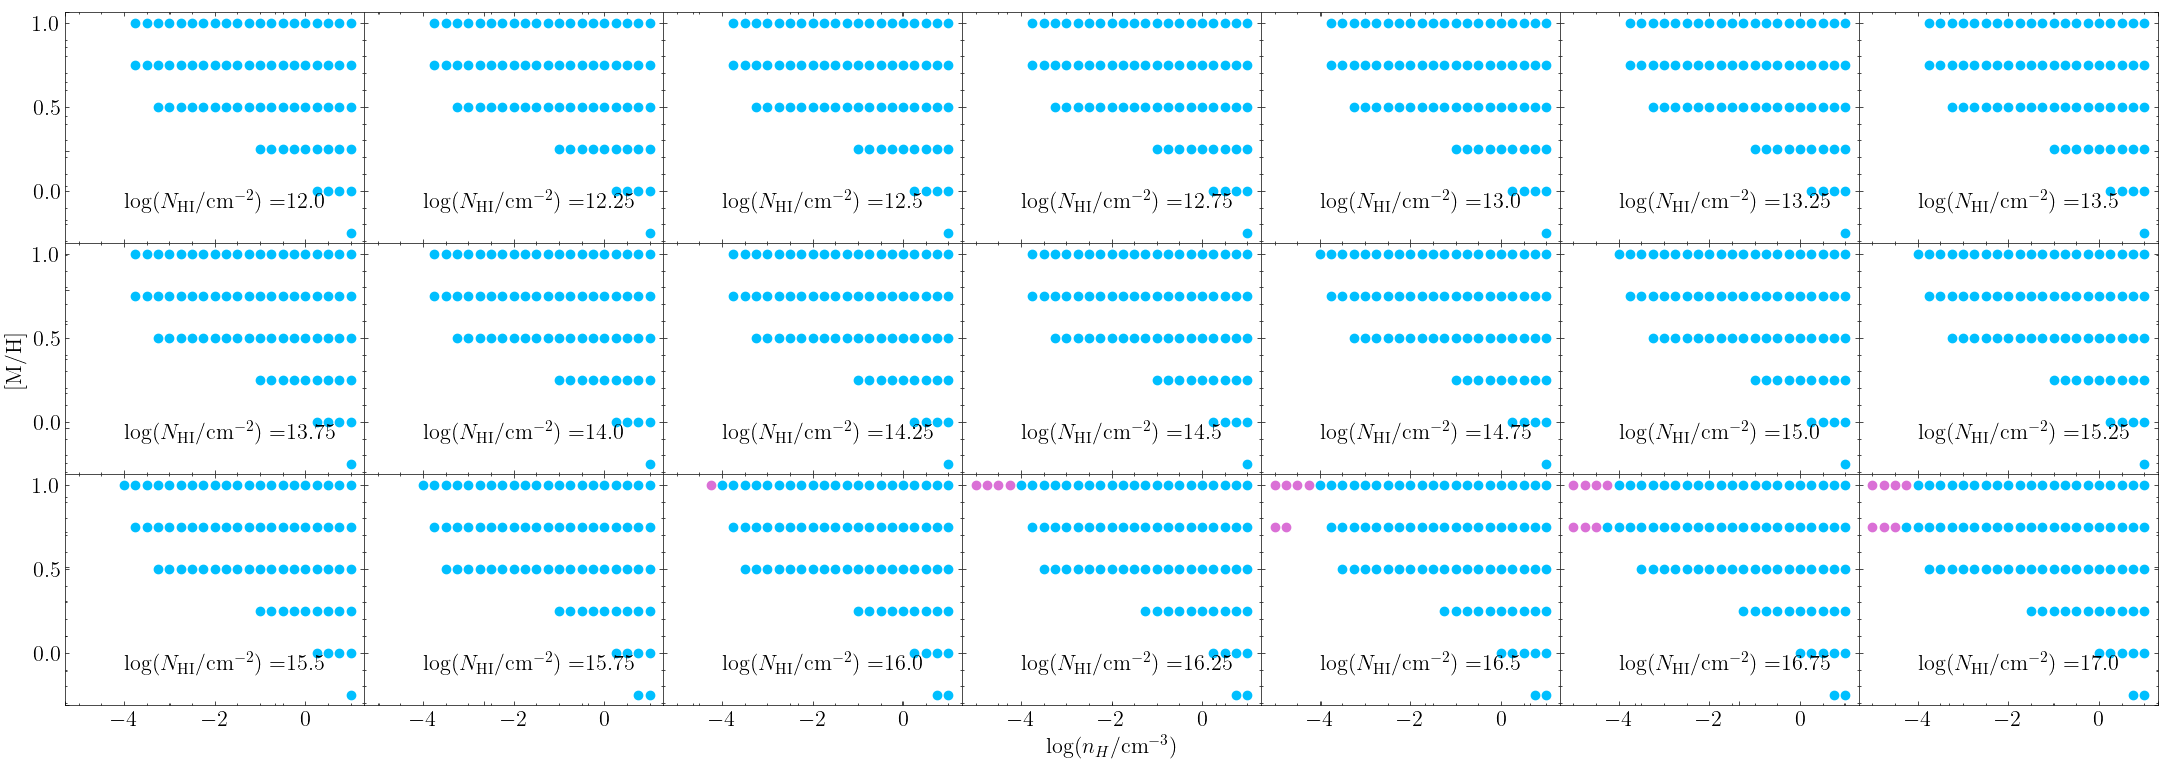

In [18]:
fig, axes = plt.subplots(3, 7, figsize=(27, 9), sharex=True, sharey=True)

for i in range(len(np.unique(low_temp_failures[:,0]))):
    
    row = i//7
    col = i%7
    
    ax = axes[row, col]
    
    logN_HI_stop = np.unique(low_temp_failures[:,0])[i]
    
    idx = (low_temp_failures[:,0] == logN_HI_stop)
    ax.scatter(low_temp_failures[idx][:,1], low_temp_failures[idx][:,2], color='deepskyblue')
    
    idx_hi = (high_temp_failures[:,0] == logN_HI_stop)
    
    if np.sum(idx_hi)!=0:
        ax.scatter(high_temp_failures[idx_hi][:,1], high_temp_failures[idx_hi][:,2], color='orchid')
    
    ax.text(x=-4, y=-.1, s=r'$\log (N_{\mathrm{HI}}/\mathrm{cm}^{-2}) = $'+'{}'.format(logN_HI_stop))
    
ax_label = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

ax_label.set_xlabel(r'$\log (n_H/\mathrm{cm}^{-3})$')
ax_label.set_ylabel(r'$\mathrm{[M/H]}$')

plt.subplots_adjust(wspace=0, hspace=0) 

In [19]:
np.unique(low_temp_failures[:,0]), np.unique(low_temp_failures[:,1]), np.unique(low_temp_failures[:,2])

(array([12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  ,
        14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  , 16.25,
        16.5 , 16.75, 17.  ]),
 array([-4.25, -4.  , -3.75, -3.5 , -3.25, -3.  , -2.75, -2.5 , -2.25,
        -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,
         0.25,  0.5 ,  0.75,  1.  ]),
 array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]))

In [20]:
high_temp_failures[:,[0,1,2]]

array([[16.  , -4.25,  1.  ],
       [16.25, -5.  ,  1.  ],
       [16.25, -4.75,  1.  ],
       [16.25, -4.5 ,  1.  ],
       [16.25, -4.25,  1.  ],
       [16.5 , -5.  ,  0.75],
       [16.5 , -5.  ,  1.  ],
       [16.5 , -4.75,  0.75],
       [16.5 , -4.75,  1.  ],
       [16.5 , -4.5 ,  1.  ],
       [16.5 , -4.25,  1.  ],
       [16.75, -5.  ,  0.75],
       [16.75, -5.  ,  1.  ],
       [16.75, -4.75,  0.75],
       [16.75, -4.75,  1.  ],
       [16.75, -4.5 ,  0.75],
       [16.75, -4.5 ,  1.  ],
       [16.75, -4.25,  1.  ],
       [17.  , -5.  ,  0.75],
       [17.  , -5.  ,  1.  ],
       [17.  , -4.75,  0.75],
       [17.  , -4.75,  1.  ],
       [17.  , -4.5 ,  0.75],
       [17.  , -4.5 ,  1.  ],
       [17.  , -4.25,  1.  ]])

In [21]:
# Stopping messages for high-temperature failures taken from the CLOUDY output files

high_temp_stop_messages = ['1.18e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 2.67e-01 at zone 54.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=3.92e+23cm; stability problems? (smallest Jeans mass=2.37e+09Mo)',
'2.62e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 6.28e-01 at zone 94.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 199% from 4.12e-03 (zone 92) to 4.32e-03 (zone 93) to 8.58e-03 (zone 94). Cloud thicker than smallest Jeans length=6.22e+23cm; stability problems? (smallest Jeans mass=2.98e+09Mo)',
'2.15e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 5.93e-01 at zone 73.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 152% from 8.90e-03 (zone 71) to 9.26e-03 (zone 72) to 1.41e-02 (zone 73). Cloud thicker than smallest Jeans length=6.22e+23cm; stability problems? (smallest Jeans mass=2.98e+09Mo)',
'1.73e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 3.53e-01 at zone 63.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=5.23e+23cm; stability problems? (smallest Jeans mass=3.15e+09Mo)',
'1.18e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 2.67e-01 at zone 54.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=3.92e+23cm; stability problems? (smallest Jeans mass=2.37e+09Mo)',
'2.65e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 6.78e-01 at zone 90.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=9.71e+23cm; stability problems? (smallest Jeans mass=6.06e+09Mo)',
'2.62e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 6.28e-01 at zone 94.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 198% from 4.12e-03 (zone 92) to 4.32e-03 (zone 93) to 8.57e-03 (zone 94). Cloud thicker than smallest Jeans length=7.40e+23cm; stability problems? (smallest Jeans mass=2.82e+09Mo)',
'2.13e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 4.88e-01 at zone 85.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=7.33e+23cm; stability problems? (smallest Jeans mass=4.64e+09Mo)',
'2.15e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 5.93e-01 at zone 73.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 152% from 8.90e-03 (zone 71) to 9.26e-03 (zone 72) to 1.41e-02 (zone 73). Cloud thicker than smallest Jeans length=6.22e+23cm; stability problems? (smallest Jeans mass=2.98e+09Mo)',
'1.73e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 3.53e-01 at zone 63.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=5.23e+23cm; stability problems? (smallest Jeans mass=3.15e+09Mo)',
'1.17e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 2.75e-01 at zone 54.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=3.90e+23cm; stability problems? (smallest Jeans mass=2.32e+09Mo)',
'2.65e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 6.78e-01 at zone 90.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=9.71e+23cm; stability problems? (smallest Jeans mass=6.06e+09Mo)',                          
'2.62e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The excitation temp of Lya exceeded the electron temp, largest value was 2.78e+03K (gas temp there was 2.51e+03K, zone 94). The ratio of radiation to gas pressure reached 6.28e-01 at zone 94.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 198% from 4.12e-03 (zone 92) to 4.32e-03 (zone 93) to 8.57e-03 (zone 94). Cloud thicker than smallest Jeans length=7.40e+23cm; stability problems? (smallest Jeans mass=2.82e+09Mo)',
'2.13e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 4.88e-01 at zone 85.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=7.33e+23cm; stability problems? (smallest Jeans mass=4.64e+09Mo).',                           
'2.15e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 5.93e-01 at zone 73.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 152% from 8.90e-03 (zone 71) to 9.26e-03 (zone 72) to 1.40e-02 (zone 73). Cloud thicker than smallest Jeans length=6.22e+23cm; stability problems? (smallest Jeans mass=2.98e+09Mo)',
'1.31e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 4.44e-01 at zone 103.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=5.32e+23cm; stability problems? (smallest Jeans mass=3.16e+09Mo)',                           
'1.73e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 3.53e-01 at zone 63.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=5.23e+23cm; stability problems? (smallest Jeans mass=3.15e+09Mo)', 
'1.18e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 2.67e-01 at zone 54.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=3.92e+23cm; stability problems? (smallest Jeans mass=2.37e+09Mo)',                                                   
'2.65e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 6.78e-01 at zone 90.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=9.71e+23cm; stability problems? (smallest Jeans mass=6.06e+09Mo)',
'2.62e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The excitation temp of Lya exceeded the electron temp, largest value was 2.78e+03K (gas temp there was 2.51e+03K, zone 94). The ratio of radiation to gas pressure reached 6.28e-01 at zone 94.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 198% from 4.12e-03 (zone 92) to 4.32e-03 (zone 93) to 8.57e-03 (zone 94). Cloud thicker than smallest Jeans length=7.40e+23cm; stability problems? (smallest Jeans mass=2.82e+09Mo).',
'2.13e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The radiation pressure jumped by 262% from 9.46e-19 (zone 4) to 2.23e-18 (zone 5) to 1.07e-17 (zone 6). Cloud thicker than smallest Jeans length=7.33e+23cm; stability problems? (smallest Jeans mass=4.64e+09Mo).',
'2.15e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 5.93e-01 at zone 73.  Caused by Lyman alpha. An ionization jump occurred elem He 2, by 152% from 8.90e-03 (zone 71) to 9.26e-03 (zone 72) to 1.40e-02 (zone 73). Cloud thicker than smallest Jeans length=6.22e+23cm; stability problems? (smallest Jeans mass=2.98e+09Mo)',
'1.31e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 4.43e-01 at zone 103.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=5.33e+23cm; stability problems? (smallest Jeans mass=3.16e+09Mo)',
'1.73e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 3.53e-01 at zone 63.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=5.23e+23cm; stability problems? (smallest Jeans mass=3.15e+09Mo)',
'1.18e+04. Calculation stopped because lowest Te reached. Iteration 3 of 3. The ratio of radiation to gas pressure reached 2.67e-01 at zone 54.  Caused by Lyman alpha. Cloud thicker than smallest Jeans length=3.92e+23cm; stability problems? (smallest Jeans mass=2.37e+09Mo)']

In [22]:
len(high_temp_stop_messages)

25

In [23]:
len(high_temp_failures)

25

Despite failures, create the main grid and save it

In [24]:
species_logN_samples = {}

In [25]:
for i in range(len(logN_HI_arr)):
    
    logN_HI = logN_HI_arr[i]
    
    # The filename corresponding to the current stopping HI column density
    filename = file_list[i]
    
    # Get list of densities and metallicities for this stopping HI column density 
    log_hdens_grid, log_metals_grid = read_grd_file(rootdir, filename)
    
    # Get average (log) HI temperatures for all grid points
    log_temps_grid = read_avr_file(rootdir, filename)
    
    # Get column densities for all species
    species_names, log_col_dens_grid = read_col_file(rootdir, filename)
    
    for j in range(len(log_hdens_arr)):
        
        log_hdens = log_hdens_arr[j]
        
        for k in range(len(log_metals_arr)):
            
            log_metals = log_metals_arr[k]
            
            # Get grid index number for the current n_H and metallicity
            idx = np.intersect1d(np.where(log_hdens_grid==log_hdens)[0], np.where(log_metals_grid==log_metals)[0])[0]
            
            # Isolate the average temperature and column density for all species
            log_temp = log_temps_grid[idx]
            log_col_dens = log_col_dens_grid[idx]
            
            # For each species
            for l in range(len(species_names)):
                
                s = species_names[l]
                
                if s not in species_logN_samples.keys():
                    
                    species_logN_samples[s] = -99.*np.ones((len(logN_HI_arr), 
                                                            len(log_hdens_arr),
                                                            len(log_metals_arr)))
                
                # Check for photoionized gas and converged logN(HI)
                if log_temp>log_T_pie_thresh and np.round(log_col_dens[0],2) == logN_HI:
                    species_logN_samples[s][i,j,k] = log_col_dens[l]

/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:397: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:397: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:397: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:397: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))
/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fitting/cloudy_fit_lib.py:397: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(co

In [26]:
# Save the main grid
output = open('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/cloudy_grids/main_grid/main_grid.pkl', 'wb')
pickle.dump(species_logN_samples, output)
output.close()